Keywords are taken from a list of Asian related racial slurs and a list of countries from East Asia and Southeast asia and the nationalities of those countries 
In this notebook I will take the keyword list and order them by the words most commonly used

In [2]:
from pandas import *
import pip._vendor.requests 
import os
import json
from dotenv import load_dotenv
import csv
import pandas as pd
from datetime import datetime
from operator import itemgetter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import numpy as np
import time
from wordcloud import WordCloud


In [ ]:
keyWordData = read_csv('rawkeywordlist.csv')
words = keyWordData['keyword'].tolist()

seen = []

#if hyphens not desired use this:

for word in words:
    newWord = word.rstrip()
    newWord = newWord.lower()
    if newWord in seen:
        continue      
    if "-" in newWord:
        unHyphenated = newWord.replace("-", " ")
        if unHyphenated not in seen:
            seen.append(unHyphenated)
            continue 
        else:
            continue 
    seen.append(newWord)


sortedSeen = sorted(seen)

df = pd.DataFrame(data={"keyword" : sortedSeen})
df.to_csv("./unsortedAsianKeywords.csv", sep=",", index=False)

In [4]:
load_dotenv()

# To get bearer token environment variable
bearer_token = os.environ.get("BEARER-TOKEN")

search_url = "https://api.twitter.com/2/tweets/counts/all"

# Optional params: start_time,end_time,since_id,until_id,next_token,granularity

In [5]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2FullArchiveTweetCountsPython"
    return r

In [6]:
def connect_to_endpoint(url, params):
    response = pip._vendor.requests.request("GET", search_url, auth=bearer_oauth, params=params)
    # print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [7]:
def query_params(next_token, queryKeyword, start, end):
   
    queryStr = f'{queryKeyword} lang:en -is:retweet place_country:gb'
    queryDict = {   'query': queryStr,
                    'granularity': 'day',
                    'start_time': start,
                    'end_time': end,
                    'next_token': next_token
                    }
    return queryDict


In [8]:
def getKeywordsListFromCsv(csvFile):
    with open(csvFile, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    del data[0]
    return data

keyWordListofLists = getKeywordsListFromCsv('unsortedAsianKeywords.csv')
print("number of keywords: " + str(len(keyWordListofLists)))
# print(keyWordListofLists)
# print(type(keyWordListofLists))
# print(type(keyWordListofLists[0]))
# print(type(keyWordListofLists[0][0]))



number of keywords: 113


In [9]:
def get_tweet_counts_to_df(queryKeyword, startDate, endDate):
    next_token = {}
    finished = False
    data = []
   
    while finished == False:
        json_response = connect_to_endpoint(search_url, query_params(next_token, queryKeyword, startDate, endDate))
        for r in json_response['data']:
            start = r['start']
            count = r['tweet_count']
            startDate = datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f%z')
            result = [startDate, count]
            data.append(result)
            
        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
        else:
            finished = True
    
    sortedData = sorted(data, key=itemgetter(0))

    df = pd.DataFrame(sortedData, columns=['date', 'tweetCount'])
    return df



In [10]:
def getSumTweetCountFromDf(tweetCountDf):
    return tweetCountDf['tweetCount'].sum()

In [11]:
def getKeywordsDfOrderedBySum(keywordList, startDate, endDate):
    keywordsAndSums = []
    for x in range(0, len(keywordList)):
        keyword = keywordList[x][0]
        df = get_tweet_counts_to_df(keyword, startDate, endDate)
        sum = getSumTweetCountFromDf(df)
        result = [keyword, sum]
        keywordsAndSums.append(result)
        time.sleep(1)
    
    sortedKeywordsBySum = sorted(keywordsAndSums, key=itemgetter(1), reverse=True)
    return pd.DataFrame(sortedKeywordsBySum, columns=['keyword', 'sum'])
    

In [12]:
keywordsAndTweetCountSumDf = getKeywordsDfOrderedBySum(keyWordListofLists, '2020-01-01T00:00:00Z', '2020-02-01T00:00:00Z')
print(keywordsAndTweetCountSumDf)

        keyword   sum
0       chinese  4069
1         china  3586
2         japan  1284
3         asian   956
4      japanese   939
..          ...   ...
108   thin eyed     0
109    timorese     0
110      yangmo     0
111      yigger     0
112  zipperhead     0

[113 rows x 2 columns]


In [14]:
keywordsAndTweetCountSumDf2 = getKeywordsDfOrderedBySum(keyWordListofLists, '2019-01-01T00:00:00Z', '2019-02-01T00:00:00Z')
print(keywordsAndTweetCountSumDf2)

           keyword   sum
0            china  3123
1          chinese  2761
2            japan  1477
3         japanese  1197
4        singapore  1146
..             ...   ...
108  squint nigger     0
109       timorese     0
110         yangmo     0
111         yigger     0
112     zipperhead     0

[113 rows x 2 columns]


Generating word clouds

In [26]:
def tweetCountDfToWordCloud(df, title):
    tempDict = df.to_dict('split')
    tempList = tempDict['data']
    frequenciesDict = {}
    for listItem in tempList:
        frequenciesDict[listItem[0]] = listItem[1]
    wc = WordCloud(width=800, height=400, background_color="black", max_words=150,  colormap='tab20c')
    wc.generate_from_frequencies(frequenciesDict)
    plt.figure(figsize = (15,15))
    plt.title(title, fontsize = 20)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")



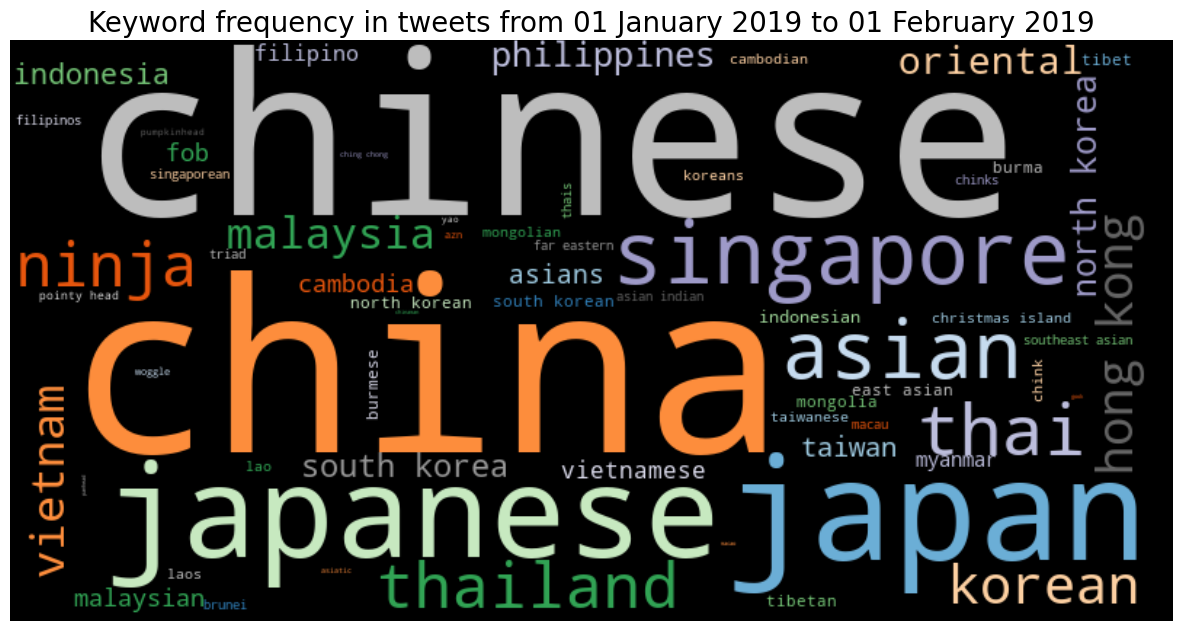

In [27]:
titleString = "Keyword frequency in tweets from 01 January 2019 to 01 February 2019"
tweetCountDfToWordCloud(keywordsAndTweetCountSumDf2, titleString)

In [28]:
print("In January 2019 the number of keywords that were used more than zero times was:")
print(np.sum(keywordsAndTweetCountSumDf2['sum'] != 0))

In January 2019 the number of keywords that were used more than zero times was:
75


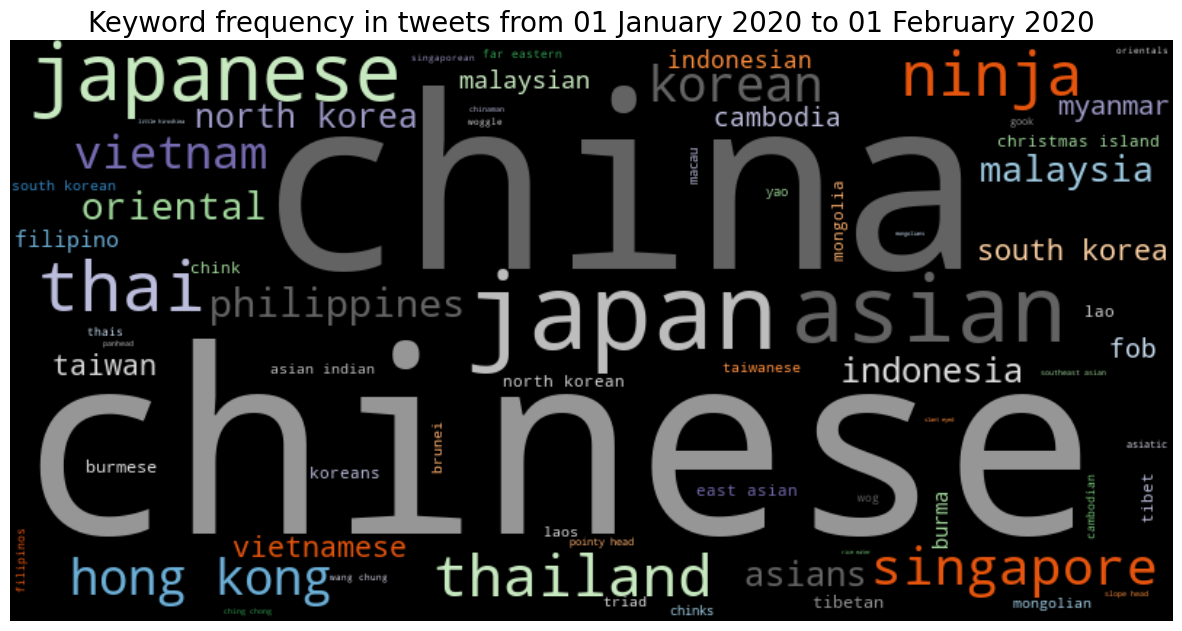

In [29]:
titleString = "Keyword frequency in tweets from 01 January 2020 to 01 February 2020"
tweetCountDfToWordCloud(keywordsAndTweetCountSumDf, titleString)

In [30]:
print("In January 2020 the number of keywords that were used more than zero times was:")
print(np.sum(keywordsAndTweetCountSumDf['sum'] != 0))

In January 2020 the number of keywords that were used more than zero times was:
75


In [31]:
pd.options.display.max_rows = 30
print("Jan 2019 dataframe:")
keywordsAndTweetCountSumDf2


Jan 2019 dataframe:


,keyword,sum
0,china,3123
1,chinese,2761
2,japan,1477
3,japanese,1197
4,singapore,1146
...,...,...
108,squint nigger,0
109,timorese,0
110,yangmo,0
111,yigger,0


In [32]:
print("Jan 2020 dataframe:")
keywordsAndTweetCountSumDf

Jan 2020 dataframe:


,keyword,sum
0,chinese,4069
1,china,3586
2,japan,1284
3,asian,956
4,japanese,939
...,...,...
108,thin eyed,0
109,timorese,0
110,yangmo,0
111,yigger,0


In [33]:

joinedDf = pd.merge(keywordsAndTweetCountSumDf, keywordsAndTweetCountSumDf2, on = 'keyword', suffixes=('2020', '2019'), how = 'inner')
joinedDf['total_19+20'] = joinedDf['sum2020'] + joinedDf['sum2019']
joinedDf.sort_values(['total_19+20'], inplace = True, ascending = False )
joinedDf

,keyword,sum2020,sum2019,total_19+20
0,chinese,4069,2761,6830
1,china,3586,3123,6709
2,japan,1284,1477,2761
4,japanese,939,1197,2136
3,asian,956,985,1941
...,...,...,...,...
88,gookaniese,0,0,0
90,gooky,0,0,0
91,japanigger,0,0,0
92,jaundy boy,0,0,0


In [34]:
print("Number of keywords used more than zero times in January 2019 or January 2020:")
print(np.sum(joinedDf['total_19+20'] != 0))

Number of keywords used more than zero times in January 2019 or January 2020:
80


Slice datatframe to exclude keywords with a sum2019 and sum 2020 of zero

In [35]:
slicedDf = joinedDf[joinedDf['total_19+20'] != 0]
slicedDf


,keyword,sum2020,sum2019,total_19+20
0,chinese,4069,2761,6830
1,china,3586,3123,6709
2,japan,1284,1477,2761
4,japanese,939,1197,2136
3,asian,956,985,1941
...,...,...,...,...
75,bruneian,0,2,2
108,thin eyed,0,1,1
85,gink,0,1,1
73,laotian,1,0,1


In [36]:
header = ["keyword"]
slicedDf.to_csv('finalAsianKeywords.csv', index = False, columns = header)